In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy

def circular_graph(r):
    g = nx.grid_graph([r, r])
    to_remove = []
    for i in g.nodes():
        j = (i[0]-r/2, i[1]-r/2)
        L = j[0]**2 + j[1]**2
        if L >= (r/2)**2:
            to_remove.append( i )
    for i in to_remove:
        g.remove_node(i)
    return g

def remove_fraction(g_tmp, fr):
    g = g_tmp.copy()
    lst = list(g.nodes())
    numpy.random.shuffle(lst)
    lst = lst[:int(len(lst)*fr)]
    g.remove_nodes_from(lst)
    return g

def largest_subgraph(h):
    sg = nx.connected_component_subgraphs(h)
    sg = list(sg)
    sg.sort(key = lambda g : len(g.nodes()), reverse=True)
    return sg[0]

def draw_graph(g):
    nodes = g.nodes()
    nodes = dict(zip(nodes,nodes))
    nx.draw(g, pos = nodes, node_size = 10)

In [87]:
def show_state_grid(Ss, x, missing = -1):
    ss = numpy.array(Ss)
    n, m = numpy.max(ss, axis = 0)
    n += 1
    m += 1
    V = numpy.zeros((n,m))
    for i, (u,v) in enumerate(Ss):
        V[v, u] = x[i]
    #V = missing * numpy.ones((n, m))
    #V[ss[:, 0], ss[:,1]] = x
    plt.imshow(V, interpolation='none', origin='lower')

In [89]:
def create_grid_mdp(states, pe = 0.0):
    
    def succ(s, a):
        return (s[0]+a[0], s[1]+a[1])

    def grid_mdp(Ss, As, aprime, pe = 0.01):
        n = len(Ss)
        P = numpy.zeros((n, n))
        sid = dict(zip(Ss, range(n)))
        for s in Ss:
            i = 0
            for a in As:
                sprime = succ(s, a)
                if sprime in Ss:
                    P[ sid[s], sid[sprime]] = pe
                    i += 1
            sprime = succ(s, aprime)
            if sprime not in Ss:
                sprime = s
            P[ sid[s], sid[sprime]] = 1 - (i-1)*pe
        return P

    Si = range(len(states)) 
    As = [(0,0), (1,0), (0,1), (-1,0), (0,-1)]
    Ps = [ grid_mdp(states, As, a, pe) for a in As ]

    return Si, states, As, Ps

In [145]:
def value_iteration(Ps, Cs, gamma, eps = 1e-4):
    # grab the number of states
    ns = Ps[0].shape[0]
    # grab the number of actions
    na = len(Ps)
    # seed the initial value function
    V = numpy.zeros((ns, 1))
    V = numpy.asmatrix(V)
    # force the cost to be a matrix
    Cs = numpy.asmatrix(Cs)
    # force the transitions to be matrices
    Ps = [ numpy.asmatrix(P) for P in Ps ]

    while 1:

        # Q is the value of being in state s and applying action a
        Q = numpy.zeros((ns, na))
        Q = numpy.asmatrix(Q)

        # for all possible actions
        for i in xrange(na):
            # $Q(a, a) = \sum_{s'} P_a(s, s')(R_a(s, s') + \gamma V(s'))$
            Q[:, i] = Cs[:, i] + gamma * (Ps[i] * V)

        # best value 
        Vnew = numpy.min(Q, axis = 1)
        # best policy so far
        policy = numpy.argmin(Q, axis = 1)
        # exit if converged
        err = numpy.sum(Vnew - V)
        if abs(err) < eps:
            return Vnew, policy
        # update value for next cycle
        V = Vnew


In [146]:
def optimal_policy(policy):
    """Convert a list of optimal actions to a policy matrix
    """
    pi = numpy.zeros((len(Ss), len(As)))
    for i,a in enumerate(policy):
        pi[i, a] = 1.0
    return pi


def epsilon_greedy(pi, eps):
    """Convert an optimal policy matrix to an epsilon greedy policy matrix

    pi : numpy.matrix
        |S| x |A|, with a numpy.sum(pi, axis=1) == 1
    """
    na   = pi.shape[1]
    opt  = numpy.where(pi > 0.5)
    nopt = numpy.where(pi < 0.5)
    pi[ :, : ] = eps / na
    pi[ opt[0],  opt[1]] += (1-eps)
    return pi

def apply_policy(Ps, pi):
    # see David Silvers notes, Lecure 2: markov decision processes, slide "
    Pnew = numpy.zeros((len(Ss),len(Ss)))
    for i in xrange(len(As)):
        # yucky. this is matlab .*
        Pnew += numpy.multiply(pi[:, i], Ps[i])
    return Pnew

def expected_steps(Q):
    I    = numpy.eye(Q.shape[0])
    ones = numpy.ones((Q.shape[0], 1))
    return numpy.dot(numpy.linalg.inv(I - Q), ones)

199
[4 4]


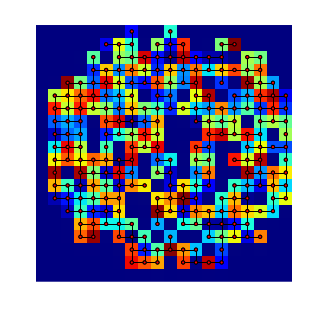

In [154]:
g = circular_graph(21)
g = remove_fraction(g, 0.2)
g = largest_subgraph(g)
draw_graph(g)
pe = 0.0
Si, Ss, As, Ps = create_grid_mdp(g.nodes(), pe = pe)
show_state_grid(Ss, Si, missing=-1)
draw_graph(g)

idx = Ss.index((4,4))#Ss.index((2,5))
print idx
Ss = numpy.asarray(Ss)
ns = Ss.shape[0]

#idx = numpy.random.randint(low = 0, high = ns)
sgi = Si[idx]
sg  = Ss[idx]
print sg

Cs = numpy.ones((len(Ss), len(As)))
Cs[idx,:] = 0.0
Vpi, policy = value_iteration(Ps, Cs, 0.99)
Vpi = numpy.asarray(Vpi).T[0]

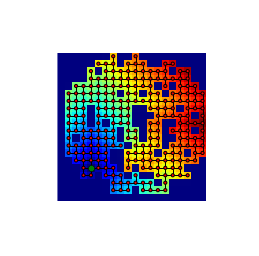

In [155]:
show_state_grid(Ss, Vpi, missing=-1)
draw_graph(g)
plt.plot(sg[0],sg[1],'go')

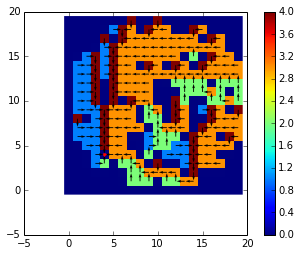

In [156]:
show_state_grid(Ss,  numpy.asarray(policy.T)[0])
plt.colorbar()
plt.plot(sg[0],sg[1],'r.')
mAs = numpy.array(As)
dxdy = mAs[(policy.T)[0], :][0]
plt.quiver(Ss[:,0],Ss[:,1], dxdy[:,0], dxdy[:,1]);



<matplotlib.colorbar.Colorbar instance at 0x95e3a28>

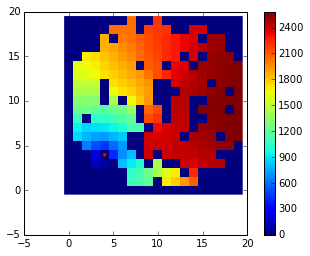

In [161]:
pi = optimal_policy(policy)
pi = epsilon_greedy(pi, 1.0)
pi = numpy.asmatrix(pi)
P = apply_policy(Ps, pi)

nongoal = numpy.where(numpy.arange(len(Ss)) != idx)[0]
P = P[nongoal,:]
P = P[:,nongoal]
T = expected_steps(P)

show_state_grid(Ss[nongoal],  T)
plt.plot(sg[0],sg[1],'r.')
plt.colorbar()